# Trabalho 2 - Inteligência Artificial - Aprendizado de Máquina

**Líder:** Leonardo Gabriel Fusineli Silva (11218841)

**Vice-líder:** Natan Hilário da Silva (11218201)

Júlio Trevisan Centanin (11218240)

Yago Augusto Bardelotte (11320724)

Gabriel Bueno Barbosa (11371263)

Gustavo Siqueira Barbosa (10728122)

Diane Damaris Dorst (11366868)


Este trabalho tem como objetivo o estudo da relação de diferentes variáveis associadas a pedidos de clientes de uma plataforma de _ecommerce_ que vende alimentos frescos (Freshmania). É realizado um preprocessamento dos dados brutos obtidos a partir da base de dados, seguido da aplicação de diferentes modelos de classificação. Ao final os modelos são comparados, sendo selecionado aquele que apresentou melhor desempenho segundo as métricas "acurácia balanceada" e "AUC".

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer

from matplotlib import pyplot as plt
import seaborn as sns

import plotly.express as px

In [2]:
cep = pd.read_excel("DataT2/Cep-20221130-170941.xlsx")
pedidos = pd.read_excel("DataT2/Pedidos Simplificado-20221129-222727.xlsx")
sku = pd.read_excel("DataT2/SKU-20221129-215730.xlsx")

Vejamos primeiramente a tabela de dados relacionados aos pedidos dos usuários. Contamos com as variáveis:

* Id Usuário;
* Data de entrega;
* CEP;
* Quebra: Se houve quebra de estoque no pedido ou não (falta de produtos para a entrega);
* Produtos: Lista de produtos no pedido;
* Cupom: Se o pedido foi feito com cupom ou não;
* Frete: Se o pedido teve frete grátis;
* Valor Final: Valor total do pedido;
* Tipo: Se o pedido é uma venda ou bonificação;
* Status: Se o pedido foi finalizado, cancelado, pago parcialmente, etc.

In [3]:
print("Número de observações:", pedidos.shape)
pedidos.head(4)

Número de observações: (18570, 11)


,Número do Pedido,Id Usuário,Data de entrega,CEP,Quebra,Produtos,Cupom,Frete,Valor Final,Tipo,Status
0,1,RURVRUlTLTQ2MjQ3MmU0YWVkMTIyNWQ=,18/08/2021,04514-040,NaN,"LT018,TS002,UK002,LT020,LT007,LT002,LT024,FB00...",NaN,Não,"R$: 187,73",Venda,Finalizado
1,2,RkxBU1pZLTU0Mjg2YzgxZDkwNzE2MjE=,18/08/2021,04546-001,NaN,"LT016,LT020,LT001,LT003,LT005,LT023,LT024,BM00...",NaN,Não,"R$: 217,19",Venda,Finalizado
2,3,QVJUQ0FSLTNhMzQ0MDk0OWMwY2M1MTk=,18/08/2021,04548-003,NaN,"LT001,LT018,TS002,NG003,FB001,MR001,UK002,RT02...",NaN,Não,"R$: 302,84",Venda,Finalizado
3,4,QU1JRUlTLTc2YzgxMDFhM2EwZDdiN2I=,18/08/2021,01233-001,NaN,"BV022,FB001,FB002,AP001,AP002,NG005,TS002,VP00...",NaN,Não,"R$: 215,76",Venda,Finalizado


Primeiramente, filtramos os dados para obter apenas os pedidos finalizados e que são caracterizados como "Venda". Pedidos com bonificação podem apresentar um viés para a análise devido aos tipos de clientes que recebem essas compras.

In [4]:
pedidos = pedidos.loc[ (pedidos.Status == "Finalizado") & (pedidos.Tipo == "Venda"), : ].reset_index(drop = True)
print("Número de observações:", pedidos.shape)

Número de observações: (17288, 11)


In [5]:
# Formatação da variável referente à quebra de estoque
pedidos.loc[pedidos.Quebra.notna(), "Quebra"] = 1
pedidos.loc[pedidos.Quebra.isna(), "Quebra"] = 0

# Formatação do valor do pedido
pedidos.loc[:, "Valor Final"] = pedidos.loc[:,"Valor Final"].str.replace("R\$: ", "", regex = True).replace("\.", "", regex = True).replace(",", ".", regex = True).astype(np.float64)

# Formatação das datas
pedidos.loc[:, "Data de entrega"] = pd.to_datetime( pedidos.loc[:, "Data de entrega"], format = "%d/%m/%Y")

selected = ["Id Usuário", "Data de entrega", "CEP", "Quebra", "Produtos", "Valor Final"]
pedidos = pedidos.filter(selected)

pedidos.head(4)

,Id Usuário,Data de entrega,CEP,Quebra,Produtos,Valor Final
0,RURVRUlTLTQ2MjQ3MmU0YWVkMTIyNWQ=,2021-08-18,04514-040,0,"LT018,TS002,UK002,LT020,LT007,LT002,LT024,FB00...",187.73
1,RkxBU1pZLTU0Mjg2YzgxZDkwNzE2MjE=,2021-08-18,04546-001,0,"LT016,LT020,LT001,LT003,LT005,LT023,LT024,BM00...",217.19
2,QVJUQ0FSLTNhMzQ0MDk0OWMwY2M1MTk=,2021-08-18,04548-003,0,"LT001,LT018,TS002,NG003,FB001,MR001,UK002,RT02...",302.84
3,QU1JRUlTLTc2YzgxMDFhM2EwZDdiN2I=,2021-08-18,01233-001,0,"BV022,FB001,FB002,AP001,AP002,NG005,TS002,VP00...",215.76


# Tratamento dos produtos

Vemos que cada pedido pode contar com um grande número de produtos diferentes, no entanto os produtos podem ser muito semelhantes entre si, como por exemplo, sucos de tamanhos diferentes ou marcas diferentes. Assim, argumenta-se que seja mais simples e intuitivo identificarmos cada pedido com base nas categorias dos produtos como forma de sumarizar as informações de cada pedido.

In [6]:
def sku_dict(sku):
    sku_dict_categoria = {}
    sku_dict_subcategoria = {}
    sku_dict_tags = {}
    for j in sku.index:
        sku_dict_categoria[sku.loc[j,"Id"]] = sku.loc[j,"Categoria"]
        sku_dict_subcategoria[sku.loc[j,"Id"]] = sku.loc[j,"Subcategoria"]
        sku_dict_tags[sku.loc[j,"Id"]] = sku.loc[j,"Tags"]
        
    return [sku_dict_categoria, sku_dict_subcategoria, sku_dict_tags]

In [7]:
sku_categoria, sku_subcategoria, sku_tags = sku_dict(sku)

In [8]:
def split_produtos(pedidos):
    pedidos = pedidos.copy()

    Categorias = []
    Subcategorias = []
    Tags = []

    for j in pedidos.index:
        categorias_list = []
        subcategorias_list = []
        tags_list = []

        produtos = pedidos.loc[j, "Produtos"].split(",")[:-1]
        for produto in produtos:

            # Se o produto está presente em um pedido, mas não na planilha de produtos, ignora
            if(produto not in list(sku_categoria.keys())):
                continue

            categoria = sku_categoria[produto]
            subcategoria = sku_subcategoria[produto]
            tags = sku_tags[produto]

            if(categoria not in categorias_list):
                categorias_list.append(categoria)
            if(subcategoria not in subcategorias_list):
                subcategorias_list.append(subcategoria)
            if(type(tags) == str):
                for tag in tags.split(","):
                    if(tag not in tags_list):
                        tags_list.append(tag)

        Categorias.append(categorias_list)
        Subcategorias.append(subcategorias_list)
        Tags.append(tags_list)

    pedidos.loc[:, "Categorias"] = Categorias
    pedidos.loc[:, "Subcategorias"] = Subcategorias
    pedidos.loc[:, "Tags"] = Tags
    
    pedidos = pedidos.filter(["Id Usuário", "Data de entrega", "", "CEP", "Quebra", "Categorias", "Subcategorias", "Tags", "Valor Final"])

    return pedidos

In [9]:
pedidos_split = split_produtos(pedidos)

pedidos_split.head(4)

,Id Usuário,Data de entrega,CEP,Quebra,Categorias,Subcategorias,Tags,Valor Final
0,RURVRUlTLTQ2MjQ3MmU0YWVkMTIyNWQ=,2021-08-18,04514-040,0,"[Iogurtes e Coalhadas, Bebidas, In Natura, Der...","[Coalhada, Laranja, Cogumelo, Creme de Leite, ...","[Kosher, A2A2, Com Sabor, Sem Glúten, Zero Adi...",187.73
1,RkxBU1pZLTU0Mjg2YzgxZDkwNzE2MjE=,2021-08-18,04546-001,0,"[Iogurtes e Coalhadas, Derivados do Leite, Lei...","[Coalhada, Creme de Leite, Leite Integral, Lei...","[Kosher, A2A2, Zero Adição de Açúcar, Natural,...",217.19
2,QVJUQ0FSLTNhMzQ0MDk0OWMwY2M1MTk=,2021-08-18,04548-003,0,"[Leites e Ovos, Iogurtes e Coalhadas, Bebidas,...","[Leite Integral, Coalhada, Laranja, Ovo Vermel...","[A2A2, Sem Glúten, Kosher, Com Sabor, Zero Adi...",302.84
3,QU1JRUlTLTc2YzgxMDFhM2EwZDdiN2I=,2021-08-18,01233-001,0,"[In Natura, Queijos, Leites e Ovos, Bebidas]","[Tomate, Búfala, Ovo Caipira, Laranja, Uva, Ág...","[A2A2, Artesanal, Sem Glúten, Zero Lactose, Ze...",215.76


In [10]:
mlb = MultiLabelBinarizer()

categorias_binary = pd.DataFrame( mlb.fit_transform(pedidos_split.Categorias), columns = ["Categorias_" + c for c in mlb.classes_] )
subcategorias_binary = pd.DataFrame( mlb.fit_transform(pedidos_split.Subcategorias), columns = ["Subcategorias_" + c for c in mlb.classes_] )
tags_binary = pd.DataFrame( mlb.fit_transform(pedidos_split.Tags), columns = ["Tags_" + c for c in mlb.classes_] )

pedidos_split = pd.concat([
    pedidos_split.filter(["Id Usuário", "Data de entrega", "CEP", "Quebra", "Valor Final"]),
    categorias_binary,
    subcategorias_binary,
    tags_binary
], axis = 1)

pedidos_split.head(4)

,Id Usuário,Data de entrega,CEP,Quebra,Valor Final,Categorias_Bebidas,Categorias_Derivados do Leite,Categorias_Doces e Antepastos,Categorias_In Natura,Categorias_Iogurtes e Coalhadas,...,Tags_Fatiado,Tags_Fracionado,Tags_Kosher,Tags_Light,Tags_Natural,Tags_Orgânico,Tags_Sem Glúten,Tags_Sem Sal,Tags_Zero Adição de Açúcar,Tags_Zero Lactose
0,RURVRUlTLTQ2MjQ3MmU0YWVkMTIyNWQ=,2021-08-18,04514-040,0,187.73,1,1,0,1,1,...,1,0,1,0,1,1,1,0,1,0
1,RkxBU1pZLTU0Mjg2YzgxZDkwNzE2MjE=,2021-08-18,04546-001,0,217.19,1,1,1,1,1,...,0,0,1,0,1,1,1,0,1,1
2,QVJUQ0FSLTNhMzQ0MDk0OWMwY2M1MTk=,2021-08-18,04548-003,0,302.84,1,1,1,1,1,...,0,1,1,0,1,1,1,0,1,1
3,QU1JRUlTLTc2YzgxMDFhM2EwZDdiN2I=,2021-08-18,01233-001,0,215.76,1,0,0,1,0,...,1,0,1,0,1,1,1,0,1,1


# Criação das labels do _churn_

A seguir são implementados os códigos que categorizam cada usuário segundo o seu _churn_ dado um período de referência.

In [11]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

In [12]:
data2 = datetime(2021,11,1)
data1 = data2 + relativedelta(months = 1)
data3 = data2 + relativedelta(months = -1)

print(data3)
print(data2)
print(data1)

2021-10-01 00:00:00
2021-11-01 00:00:00
2021-12-01 00:00:00


In [13]:
def calcular_churn(pedidos, mes, ano):
    
    data2 = datetime(ano, mes, 1)
    data1 = data2 + relativedelta(months = 1)
    data3 = data2 + relativedelta(months = -1)
    
    janela1 = (pedidos.loc[:, "Data de entrega"] >= data2) & (pedidos.loc[:, "Data de entrega"] < data1)
    janela2 = (pedidos.loc[:, "Data de entrega"] >= data3) & (pedidos.loc[:, "Data de entrega"] < data2)
    janela3 = pedidos.loc[:, "Data de entrega"] < data3
    
    # Obtém todos os usuários com pedidos até o período da janela de interesse
    todos_usuarios = pedidos.loc[ pedidos.loc[:, "Data de entrega"] < data1 , "Id Usuário"].unique()
    
    usuarios_janela1 = pedidos.loc[janela1, :].loc[:,"Id Usuário"].unique()
    usuarios_janela2 = pedidos.loc[janela2, :].loc[:,"Id Usuário"].unique()
    usuarios_janela3 = pedidos.loc[janela3, :].loc[:,"Id Usuário"].unique()
    
    classes_usuarios = {}
    # Percorre todos os usuários, definindo suas categorias churn
    for usuario in todos_usuarios:
        if(usuario not in usuarios_janela1):
            classes_usuarios[usuario] = "Lost"
            continue
        if(usuario in usuarios_janela1 and usuario in usuarios_janela2):
            classes_usuarios[usuario] = "Retained"
            continue
        if(usuario in usuarios_janela1 and usuario in usuarios_janela3):
            classes_usuarios[usuario] = "Lagger"
            continue
        if(usuario in usuarios_janela1 and usuario not in usuarios_janela2 and usuario not in usuarios_janela3):
            classes_usuarios[usuario] = "New"
            continue
    
    classes_usuarios = pd.DataFrame({"Usuário": list(classes_usuarios.keys()), "Churn": list(classes_usuarios.values())})
    
    return classes_usuarios

In [14]:
calcular_churn(pedidos, 11, 2022)

,Usuário,Churn
0,RURVRUlTLTQ2MjQ3MmU0YWVkMTIyNWQ=,Retained
1,RkxBU1pZLTU0Mjg2YzgxZDkwNzE2MjE=,Retained
2,QVJUQ0FSLTNhMzQ0MDk0OWMwY2M1MTk=,Retained
3,QU1JRUlTLTc2YzgxMDFhM2EwZDdiN2I=,Retained
4,UEFUUk9TLTllZGFkNDc0YjhkODJlNzk=,Retained
...,...,...
1245,VkVSUk9TLTM5OGE4ZjAzYWE2YTk1OWI=,New
1246,TUFSR09NLWMwMzVkNTZkMDEwYTdkMjc=,New
1247,QU5HU0lNLTI2MjFmNWM3YjNmYjFmYmQ=,New
1248,QU5ETUVOLTU1YmE5OTUyZmQ1MjJlZTM=,New


In [15]:
meses = [8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
anos = [2021, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022]


historico_churn = pd.DataFrame({"Usuário": pedidos.loc[:, "Id Usuário"].unique()})
colnames = ["Usuário"]

for mes, ano in zip(meses, anos):
    churn_table = calcular_churn(pedidos, mes, ano)  
    colnames.append( str(mes) +"-"+ str(ano) )
    
    historico_churn = historico_churn.merge(churn_table, on = "Usuário", how = "outer")
    historico_churn.columns = colnames

historico_churn

,Usuário,8-2021,9-2021,10-2021,11-2021,12-2021,1-2022,2-2022,3-2022,4-2022,5-2022,6-2022,7-2022,8-2022,9-2022,10-2022,11-2022
0,RURVRUlTLTQ2MjQ3MmU0YWVkMTIyNWQ=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained
1,RkxBU1pZLTU0Mjg2YzgxZDkwNzE2MjE=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained
2,QVJUQ0FSLTNhMzQ0MDk0OWMwY2M1MTk=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained
3,QU1JRUlTLTc2YzgxMDFhM2EwZDdiN2I=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained
4,UEFUUk9TLTllZGFkNDc0YjhkODJlNzk=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Lost,Lagger,Retained,Retained,Retained
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,VkVSUk9TLTM5OGE4ZjAzYWE2YTk1OWI=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New
1246,TUFSR09NLWMwMzVkNTZkMDEwYTdkMjc=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New
1247,QU5HU0lNLTI2MjFmNWM3YjNmYjFmYmQ=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New
1248,QU5ETUVOLTU1YmE5OTUyZmQ1MjJlZTM=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New


In [16]:
historico_churn

,Usuário,8-2021,9-2021,10-2021,11-2021,12-2021,1-2022,2-2022,3-2022,4-2022,5-2022,6-2022,7-2022,8-2022,9-2022,10-2022,11-2022
0,RURVRUlTLTQ2MjQ3MmU0YWVkMTIyNWQ=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained
1,RkxBU1pZLTU0Mjg2YzgxZDkwNzE2MjE=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained
2,QVJUQ0FSLTNhMzQ0MDk0OWMwY2M1MTk=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained
3,QU1JRUlTLTc2YzgxMDFhM2EwZDdiN2I=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained
4,UEFUUk9TLTllZGFkNDc0YjhkODJlNzk=,New,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Retained,Lost,Lagger,Retained,Retained,Retained
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,VkVSUk9TLTM5OGE4ZjAzYWE2YTk1OWI=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New
1246,TUFSR09NLWMwMzVkNTZkMDEwYTdkMjc=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New
1247,QU5HU0lNLTI2MjFmNWM3YjNmYjFmYmQ=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New
1248,QU5ETUVOLTU1YmE5OTUyZmQ1MjJlZTM=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New


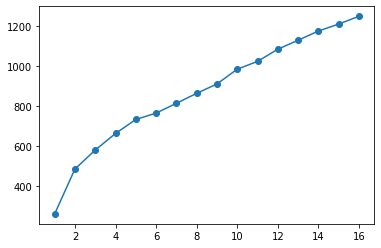

In [17]:
# Número de usuários no sistema ao longo do tempo
n_clientes = list( 1250 - historico_churn.isna().sum() )[1:]
mes = np.arange(1, len(n_clientes)+1)

plt.plot(mes, n_clientes, "-o")
plt.show()

# Construção dos modelos de classificação

Escolhemos para a construção dos modelos de classificação um único mês, que será utilizado para o treinamento

In [18]:
pedidos_split.head(4)

,Id Usuário,Data de entrega,CEP,Quebra,Valor Final,Categorias_Bebidas,Categorias_Derivados do Leite,Categorias_Doces e Antepastos,Categorias_In Natura,Categorias_Iogurtes e Coalhadas,...,Tags_Fatiado,Tags_Fracionado,Tags_Kosher,Tags_Light,Tags_Natural,Tags_Orgânico,Tags_Sem Glúten,Tags_Sem Sal,Tags_Zero Adição de Açúcar,Tags_Zero Lactose
0,RURVRUlTLTQ2MjQ3MmU0YWVkMTIyNWQ=,2021-08-18,04514-040,0,187.73,1,1,0,1,1,...,1,0,1,0,1,1,1,0,1,0
1,RkxBU1pZLTU0Mjg2YzgxZDkwNzE2MjE=,2021-08-18,04546-001,0,217.19,1,1,1,1,1,...,0,0,1,0,1,1,1,0,1,1
2,QVJUQ0FSLTNhMzQ0MDk0OWMwY2M1MTk=,2021-08-18,04548-003,0,302.84,1,1,1,1,1,...,0,1,1,0,1,1,1,0,1,1
3,QU1JRUlTLTc2YzgxMDFhM2EwZDdiN2I=,2021-08-18,01233-001,0,215.76,1,0,0,1,0,...,1,0,1,0,1,1,1,0,1,1


In [19]:
colunas_numericas = list(pedidos_split.columns[3:])

agg_dict = dict(zip(colunas_numericas, ["sum"] * len(colunas_numericas)))
agg_dict["CEP"] = "first"

In [20]:
def create_dataset_mes_ano(pedidos, mes, ano):
    '''
        Gera a tabela final para os algoritmos de classificação considerando um mês em específico.
    '''
    
    data1 = datetime(ano, mes, 1)
    data2 = data1 + relativedelta(months = 1)

    janela = (pedidos.loc[:, "Data de entrega"] >= data1) & (pedidos.loc[:, "Data de entrega"] < data2)

    # Pedidos dentro do mês especificado
    pedidos_mes = pedidos.loc[janela, :]
    # Pedidos agrupados por usuário
    pedidos_mes_usuario = (
        pedidos_mes.
        groupby("Id Usuário").
        agg(agg_dict).
        merge(pedidos_mes.groupby("Id Usuário").count().iloc[:,0].reset_index().rename(columns = {"Data de entrega": "Número de pedidos"}), on = "Id Usuário") # Concatenando ao número de pedidos do usuário
    )
    pedidos_mes_usuario = pedidos_mes_usuario.loc[:, ["Id Usuário", "Número de pedidos"] + colunas_numericas ]

    churn_mes_atual = calcular_churn(pedidos, mes, ano).rename(columns = {"Usuário": "Id Usuário", "Churn": "Churn mês atual"})

    if(mes == 12):
        churn_proximo_mes = calcular_churn(pedidos, 1, ano+1).rename(columns = {"Usuário": "Id Usuário"})
    else:
        churn_proximo_mes = calcular_churn(pedidos, mes+1, ano).rename(columns = {"Usuário": "Id Usuário"})
    churn_proximo_mes = churn_proximo_mes.rename(columns = {"Churn": "Churn próximo"})

    pedidos_mes_usuario = pedidos_mes_usuario.merge(churn_mes_atual, on = "Id Usuário").merge(churn_proximo_mes, on = "Id Usuário")

    return pedidos_mes_usuario

def create_dataset(pedidos, meses, anos):
    '''
        Gera a tabela final para os algoritmos de classificação.
    '''
    
    df = pd.DataFrame()
    for mes, ano in zip(meses, anos):
        pedidos_mes_ano = create_dataset_mes_ano(pedidos, mes, ano)
        df = pd.concat([df, pedidos_mes_ano], axis = 0)    
    
    return df

In [21]:
meses = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
anos = [2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022]

df = create_dataset(pedidos_split, meses, anos)
df.head(4)

,Id Usuário,Número de pedidos,Quebra,Valor Final,Categorias_Bebidas,Categorias_Derivados do Leite,Categorias_Doces e Antepastos,Categorias_In Natura,Categorias_Iogurtes e Coalhadas,Categorias_Leites e Ovos,...,Tags_Kosher,Tags_Light,Tags_Natural,Tags_Orgânico,Tags_Sem Glúten,Tags_Sem Sal,Tags_Zero Adição de Açúcar,Tags_Zero Lactose,Churn mês atual,Churn próximo
0,Q0FJT0xJLWI5ZjAzYmIxODZhZGU4YTg=,1,0,131.95,0,1,1,0,0,0,...,1,0,0,0,1,0,1,1,New,Retained
1,Q0FJTEFVLWI1NTZlZGY3NWUzYTllMmY=,1,0,104.91,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,New,Lost
2,Q0FNQklTLTUxOTZkZGE0MGEwZjMwYzg=,5,0,627.18,3,1,2,5,5,5,...,5,0,3,0,5,0,3,3,Retained,Retained
3,Q0FNQlVTLTNmMzNmYTVhYWI2YTdmNzc=,1,0,102.43,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,New,Lost


In [22]:
df.loc[:, "Churn próximo"].value_counts() / df.shape[0]

Retained    0.751347
Lost        0.248653
Name: Churn próximo, dtype: float64

In [23]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

In [24]:
X = df.loc[:, df.columns[1:-1]]
y = df.loc[:, "Churn próximo"].copy()
y.loc[y == "Retained"] = 1
y.loc[y == "Lost"] = 0
y = y.astype(int)

dummies_mes_atual = pd.get_dummies(X.loc[:,"Churn mês atual"]).rename(columns = {"Lagger": "Mês atual_Lagger", "New": "Mês atual_New", "Retained": "Mês atual_Retained"})
X = pd.concat([X.loc[:, X.columns[:-1]], dummies_mes_atual], axis = 1)

X.loc[:, "Quebra"] = X.loc[:, "Quebra"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state=42)

### Regressão Logística

In [25]:
logistic_model = LogisticRegression(solver = "newton-cg")
logistic_model.fit(X_train, y_train)

y_pred_train_logistic = logistic_model.predict(X_train)
y_pred_test_logistic = logistic_model.predict(X_test)

y_prob_train_logistic = logistic_model.predict_proba(X_train)[:,1]
y_prob_test_logistic = logistic_model.predict_proba(X_test)[:,1]

accuracy_logistic = accuracy_score(y_test, y_pred_test_logistic)
balanced_accuracy_logistic = balanced_accuracy_score(y_test, y_pred_test_logistic)
auc_logistic = roc_auc_score(y_test, y_prob_test_logistic)
confusion_logistic = confusion_matrix(y_test, y_pred_test_logistic)

print("Acurácia:", accuracy_logistic)
print("Acurácia balanceada:", balanced_accuracy_logistic)
print("AUC:", auc_logistic)
print("Matriz de confusão:\n", confusion_logistic)

Acurácia: 0.7983104540654699
Acurácia balanceada: 0.6648876404494382
AUC: 0.7816877838871623
Matriz de confusão:
 [[ 94 141]
 [ 50 662]]


### XGBoost

In [26]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

y_prob_train_xgb = xgb_model.predict_proba(X_train)[:,1]
y_prob_test_xgb = xgb_model.predict_proba(X_test)[:,1]

accuracy_xgb = accuracy_score(y_test, y_pred_test_xgb)
balanced_accuracy_xgb = balanced_accuracy_score(y_test, y_pred_test_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_test_xgb)
confusion_xgb = confusion_matrix(y_test, y_pred_test_xgb)

print("Acurácia:", accuracy_xgb)
print("Acurácia balanceada:", balanced_accuracy_xgb)
print("AUC:", auc_xgb)
print("Matriz de confusão:\n", confusion_xgb)

Acurácia: 0.795142555438226
Acurácia balanceada: 0.6670571360267751
AUC: 0.7643467606980636
Matriz de confusão:
 [[ 97 138]
 [ 56 656]]


### Árvore de Decisão

In [27]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

y_prob_train_dt = dt_model.predict_proba(X_train)[:,1]
y_prob_test_dt = dt_model.predict_proba(X_test)[:,1]

accuracy_dt = accuracy_score(y_test, y_pred_test_dt)
balanced_accuracy_dt = balanced_accuracy_score(y_test, y_pred_test_dt)
auc_dt = roc_auc_score(y_test, y_prob_test_dt)
confusion_dt = confusion_matrix(y_test, y_pred_test_dt)

print("Acurácia:", accuracy_dt)
print("Acurácia balanceada:", balanced_accuracy_dt)
print("AUC:", auc_dt)
print("Matriz de confusão:\n", confusion_dt)

Acurácia: 0.7096092925026399
Acurácia balanceada: 0.6272800621563471
AUC: 0.6353155629930672
Matriz de confusão:
 [[109 126]
 [149 563]]


### LGBM

In [28]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

y_pred_train_lgbm = lgbm_model.predict(X_train)
y_pred_test_lgbm = lgbm_model.predict(X_test)

y_prob_train_lgbm = lgbm_model.predict_proba(X_train)[:,1]
y_prob_test_lgbm = lgbm_model.predict_proba(X_test)[:,1]

accuracy_lgbm = accuracy_score(y_test, y_pred_test_lgbm)
balanced_accuracy_lgbm = balanced_accuracy_score(y_test, y_pred_test_lgbm)
auc_lgbm = roc_auc_score(y_test, y_prob_test_lgbm)
confusion_lgbm = confusion_matrix(y_test, y_pred_test_lgbm)

print("Acurácia:", accuracy_lgbm)
print("Acurácia balanceada:", balanced_accuracy_lgbm)
print("AUC:", auc_lgbm)
print("Matriz de confusão:\n", confusion_lgbm)

Acurácia: 0.8120380147835269
Acurácia balanceada: 0.6882709777671527
AUC: 0.7699647382261535
Matriz de confusão:
 [[104 131]
 [ 47 665]]


### Random Forest

In [29]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

y_prob_train_rf = rf_model.predict_proba(X_train)[:,1]
y_prob_test_rf = rf_model.predict_proba(X_test)[:,1]

accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_test_rf)
auc_rf = roc_auc_score(y_test, y_prob_test_rf)
confusion_rf = confusion_matrix(y_test, y_pred_test_rf)

print("Acurácia:", accuracy_rf)
print("Acurácia balanceada:", balanced_accuracy_rf)
print("AUC:", auc_rf)
print("Matriz de confusão:\n", confusion_rf)

Acurácia: 0.7898627243928195
Acurácia balanceada: 0.680650848673201
AUC: 0.7630797274683242
Matriz de confusão:
 [[109 126]
 [ 73 639]]


### KNN

In [30]:
X_train_padr = X_train.copy()
X_test_padr = X_test.copy()

n = len( X_train_padr.loc[:, "Valor Final"] )
mean_v = np.mean( X_train_padr.loc[:, "Valor Final"] )
sd_v = np.sqrt( np.sum( (X_train_padr.loc[:, "Valor Final"] - mean_v)**2 ) / (n-1) )

X_train_padr.loc[:, "Valor Final"] = ( X_train_padr.loc[:, "Valor Final"] - mean_v ) / sd_v
X_test_padr.loc[:, "Valor Final"] = ( X_test_padr.loc[:, "Valor Final"] - mean_v ) / sd_v

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_padr, y_train)

y_pred_train_knn = knn_model.predict(X_train_padr)
y_pred_test_knn = knn_model.predict(X_test_padr)

y_prob_train_knn = knn_model.predict_proba(X_train_padr)[:,1]
y_prob_test_knn = knn_model.predict_proba(X_test_padr)[:,1]

accuracy_knn = accuracy_score(y_test, y_pred_test_knn)
balanced_accuracy_knn = balanced_accuracy_score(y_test, y_pred_test_knn)
auc_knn = roc_auc_score(y_test, y_prob_test_knn)
confusion_knn = confusion_matrix(y_test, y_pred_test_knn)

print("Acurácia:", accuracy_knn)
print("Acurácia balanceada:", balanced_accuracy_knn)
print("AUC:", auc_knn)
print("Matriz de confusão:\n", confusion_knn)

Acurácia: 0.7793030623020063
Acurácia balanceada: 0.6351422424097538
AUC: 0.6934317475496055
Matriz de confusão:
 [[ 82 153]
 [ 56 656]]


# Comparação dos modelos

In [31]:
metrics = pd.DataFrame({
    "Regressão Logística": [accuracy_logistic, balanced_accuracy_logistic, auc_logistic],
    "XGBoost": [accuracy_xgb, balanced_accuracy_xgb, auc_xgb],
    "Árvore de Decisão": [accuracy_dt, balanced_accuracy_dt, auc_dt],
    "LGBM": [accuracy_lgbm, balanced_accuracy_lgbm, auc_lgbm],
    "Random Forest": [accuracy_rf, balanced_accuracy_rf, auc_rf],
    "KNN": [accuracy_knn, balanced_accuracy_knn, auc_knn],
})
metrics.index = ['Acurácia', 'Acurácia Balanceada', 'AUC']

metrics = np.transpose(metrics).sort_values("Acurácia Balanceada", ascending = False)
metrics

,Acurácia,Acurácia Balanceada,AUC
LGBM,0.812038,0.688271,0.769965
Random Forest,0.789863,0.680651,0.763080
XGBoost,0.795143,0.667057,0.764347
Regressão Logística,0.798310,0.664888,0.781688
KNN,0.779303,0.635142,0.693432
Árvore de Decisão,0.709609,0.627280,0.635316


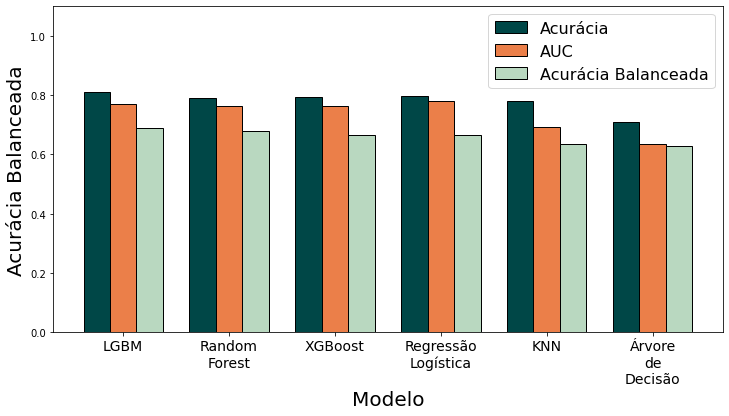

In [32]:
fig = plt.figure(figsize = (12,6))

colnames = list(metrics.index)
for i in range(len(colnames)):
    colnames[i] = colnames[i].replace(" ", "\n")
    
ind = np.arange(len(colnames))
width = 0.25
location = ind + width
plt.xticks(location, colnames)
    
plt.bar( ind, metrics["Acurácia"], width, edgecolor = "black", label = "Acurácia", color = "#004747")
plt.bar( ind+width, metrics["AUC"], width, edgecolor = "black", label = "AUC", color = "#EB7F49")
plt.bar( ind+2*width, metrics["Acurácia Balanceada"], width, edgecolor = "black", label = "Acurácia Balanceada", color = "#b9d8c0")

plt.xlabel("Modelo", size = 20)
plt.ylabel("Acurácia Balanceada", size = 20)
plt.xticks(size = 14)

plt.legend(prop={'size': 16})

plt.ylim(0,1.1)
plt.show()

Ao final, optamos pela escolha do modelo segundo o critério da Acurácia Balanceada. Utilizamos assim o método _LightGBM_ para a aplicação final dos dados. A seguir são apresentadas as variáveis de maior importância identificadas pelo modelo LGBM para a separação das classes de _Churn_.

In [33]:
top10_features = pd.DataFrame({
    "Feature": X.columns,
    "Frequência": lgbm_model.feature_importances_ / np.sum(lgbm_model.feature_importances_) * 100,
    "Importância": [str(v) + "%" for v in np.round(lgbm_model.feature_importances_ / np.sum(lgbm_model.feature_importances_) * 100, 2)]
}).sort_values("Frequência", ascending = False).head(10).reset_index(drop = True)
top10_features

,Feature,Frequência,Importância
0,Valor Final,21.900000,21.9%
1,Categorias_Queijos,3.633333,3.63%
2,Tags_Zero Lactose,3.500000,3.5%
3,Subcategorias_Leite Integral,2.733333,2.73%
4,Tags_Natural,2.600000,2.6%
5,Categorias_Derivados do Leite,2.433333,2.43%
6,Tags_Kosher,2.366667,2.37%
7,Subcategorias_Iogurte,2.333333,2.33%
8,Categorias_Iogurtes e Coalhadas,2.133333,2.13%
9,Subcategorias_Frescal e Ricota,2.033333,2.03%


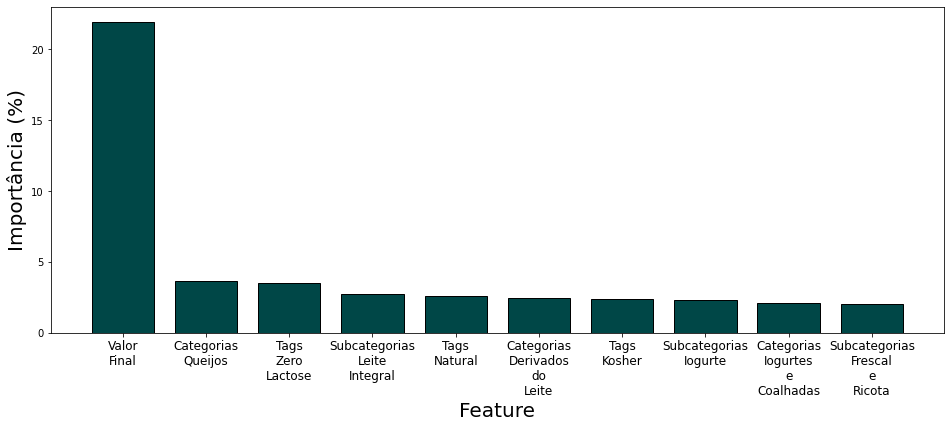

In [34]:
ind = np.arange(0, 40, 4)
width = 3
colnames = [s.replace("_", "\n").replace(" ", "\n") for s in top10_features["Feature"]]

plt.figure(figsize = (16,6))

plt.bar(ind, top10_features["Frequência"], width, color = "#004747", edgecolor = "black")

plt.xlabel("Feature", size = 20)
plt.ylabel("Importância (%)", size = 20)
plt.xticks(ind, colnames, size = 12)

plt.show()